In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ivolat3
import jpxtime3

In [3]:
s_df = pd.read_pickle('./data/s.pickle')
op_pn1 = pd.read_pickle('./data/op1.pickle')
op_pn2 = pd.read_pickle('./data/op2.pickle')
op_pn = {'1803': op_pn1, '1804': op_pn2}

In [4]:
def plot_iv(t0, t1, maturity):
    s0 = s_df.loc[t0, maturity]
    s1 = s_df.loc[t1, maturity]
    iv0 = op_pn[maturity].loc[t0]['iv']
    iv1 = op_pn[maturity].loc[t1]['iv']
    
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(iv1.index, iv1, c='b', label=t1)
    ax.plot(iv0.index, iv0, c='b', linestyle='--', linewidth=1, label=t0)
    
    y_min = min(iv0.min(), iv1.min())
    y_max = max(iv0.max(), iv1.max())
    ax.vlines(s1, y_min, y_max, linewidth=1)
    ax.vlines(s0, y_min, y_max, linewidth=1, linestyle='--')
    plt.legend(loc='lower left')
    plt.show()

In [5]:
class Portfolio:
    def __init__(self, t0, positions):
        t0 = pd.to_datetime(t0)
        self.positions = positions
        self.df = self.make_portfolio(t0)


    def make_portfolio(self, t0):
        df = pd.DataFrame([], columns=[
            'qty', 'maturity', 'right', 'price', 'iv', 'delta', 'gamma', 'vega', 'theta'])
        for i, p in enumerate(self.positions):
            qty = p['qty']
            maturity = p['maturity']
            right = p['right']
            
            if right.lower() == 'f':
                p['k'] = None
                pname = '{}{}'.format(maturity, right)
                p['price'] = s_df.loc[t0, maturity]
                p['iv'] = None
                p['delta'] = qty
                p['gamma'] = 0
                p['vega'] = 0
                p['theta'] = 0
            else:
                k = p['k']
                pname = '{}{}{}'.format(maturity, right, k)
                p['price'] = op_pn[maturity].loc[t0].loc[k, 'price']
                sigma, delta, gamma, vega, theta = self.get_greeks(
                    t0, qty, maturity, right, k)
                p['iv'] = sigma
                p['delta'] = delta
                p['gamma'] = gamma
                p['vega'] = vega
                p['theta'] = theta

            df.loc[i] = pd.Series(p)
        df.loc['sum'] = df.loc[:, 'delta':'theta'].sum()
        return df

    def get_greeks(self, t0, qty, maturity, right, k):
        s0 = s_df.loc[t0, maturity]
        r = 0.001
        t = jpxtime3.get_t(t0, jpxtime3.get_sq(maturity))
        sigma = op_pn[maturity].loc[t0].loc[k, 'iv']
        delta = qty * ivolat3.delta(s0, k, r, 0, t, sigma, right)
        gamma = qty * ivolat3.gamma(s0, k, r, 0, t, sigma)
        vega = qty * ivolat3.vega(s0, k, r, 0, t, sigma) * 0.01
        theta = qty * ivolat3.theta(s0, k, r, 0, t, sigma, right) / 365
        return sigma, delta, gamma, vega, theta
    
    def get_status(self, t0):
        t0 = pd.to_datetime(t0)
        current_df = self.make_portfolio(t0)
        for r in self.df.index[:-1]:
            pl = (current_df.loc[r, 'price'] - self.df.loc[r, 'price']) * self.df.loc[r, 'qty']
            current_df.loc[r, 'P/L'] = pl
        current_df.loc['sum', 'P/L'] = current_df['P/L'].sum()
        return current_df

### 2018年4月限 @2018年3月2日

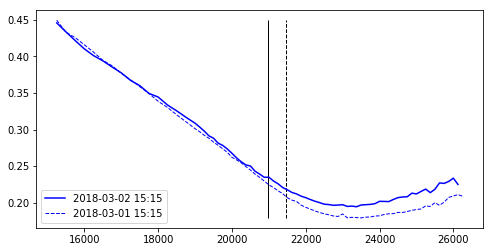

In [6]:
plot_iv('2018-03-01 15:15', '2018-03-02 15:15', '1804')

#### カバードコールを組んで見る

* コール23000(18年4月限)を1枚ショート
* 先物(18年4月限)を0.09枚ロング

In [7]:
p = Portfolio('2018-03-02 15:15',
              [{'qty': -1, 'maturity': '1804', 'right': 'C', 'k': 23000},
               {'qty': 0.09, 'maturity': '1804', 'right': 'F'}])
p.df

,qty,maturity,right,price,iv,delta,gamma,vega,theta
0,-1,1804,C,55.8013,0.19705,-0.088706,-0.000115,-11.39536,2.694784
1,0.09,1804,F,20974.1000,None,0.090000,0.000000,0.00000,0.000000
sum,NaN,NaN,NaN,NaN,NaN,0.001294,-0.000115,-11.39536,2.694784


### 2018年4月限 @2018年3月5日

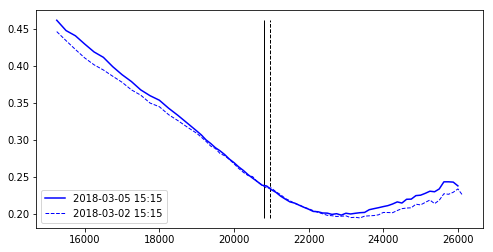

In [8]:
plot_iv('2018-03-02 15:15', '2018-03-05 15:15', '1804')

In [9]:
p.get_status('2018-03-05 15:15')

,qty,maturity,right,price,iv,delta,gamma,vega,theta,P/L
0,-1,1804,C,38.8571,0.200565,-0.066809,-0.000095,-8.780012,2.276524,16.9442
1,0.09,1804,F,20806.1000,None,0.090000,0.000000,0.000000,0.000000,-15.1200
sum,NaN,NaN,NaN,NaN,NaN,0.023191,-0.000095,-8.780012,2.276524,1.8242


### 2018年4月限 @2018年3月6日

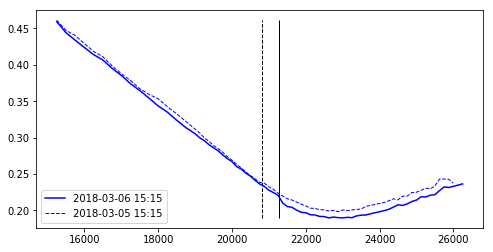

In [10]:
plot_iv('2018-03-05 15:15', '2018-03-06 15:15', '1804')

In [11]:
p.get_status('2018-03-06 15:15')

,qty,maturity,right,price,iv,delta,gamma,vega,theta,P/L
0,-1,1804,C,65.1596,0.189611,-0.107228,-0.000142,-12.634479,3.17997,-9.3583
1,0.09,1804,F,21281.7000,None,0.090000,0.000000,0.000000,0.00000,27.6840
sum,NaN,NaN,NaN,NaN,NaN,-0.017228,-0.000142,-12.634479,3.17997,18.3257
